In [1]:
import hyperspy.api as hs                 # hyperspectral data processing
import h5py                               # to handle .h5 files
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2                                # Image analysis
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from datetime import datetime             # For easily parsing timestamps
import warnings
#warnings.filterwarnings("ignore")         # Remove unnecessary pyplot warnings, but doesn't seem to work
from scipy.interpolate import interp1d

File handling functions

In [2]:
def get_filepaths(folder):
    # Automatically get all filepaths in example folder in a sorted list
    fpaths = []
    _, _, fnames = next(walk(folder)) # ignores other outputs of this
    for fname in fnames:
        fpaths.append(folder+fname)

    # Automatically place into numerical order rather than 1, 10, 11
    fpaths = natsorted(fpaths)
    return fpaths

h5py data extraction functions

In [3]:
# function for extracting data from h5py

def get_h5py_contents(f):
    # First start by finding the 'keys' (i.e. folder headings)
    def allkeys(obj):
        "Recursively find all keys in an h5py.Group."
        keys = (obj.name,)
        if isinstance(obj, h5py.Group):
            for key, value in obj.items():
                if isinstance(value, h5py.Group):
                    keys = keys + allkeys(value)
                else:
                    keys = keys + (value.name,)
        return keys
    keys = allkeys(f)

    # Now let's check each folder for any attributes and print them all out
    for key in keys:
        print(key)
        attrs = list(f[key].attrs.keys())
        if attrs != []:
            print('\t',attrs)

def get_timestamps(fpaths):
    # Here we will extract the time associated with each frame from the timestamp data
    ts = []
    tstamps = []
    for i,fpath in enumerate(fpaths):
        # Load file
        f = h5py.File(fpath,'r')
        # Access timestamp
        tstamp = list(f['Cube/Timestamp'])[0].astype(str)
        # Remove the date and keep the time
        tstamp = tstamp.split(sep=' ')[1]
        tstamps.append(tstamp)
        # Load tstamp string into correct datetime format
        t0 = datetime.strptime(tstamps[0], "%H:%M:%S.%f")
        t1 = datetime.strptime(tstamps[i], "%H:%M:%S.%f")
        # Calculate difference between current frame and initial frame in seconds
        diff = t1-t0
        t = diff.total_seconds()
        # append result
        ts.append(t)
    return ts

def extract_continuous_ts(ts):
    """Returns time series cut down to first continuous chunk"""
    diff0 = ts[1]-ts[0]
    tlast=0
    i=0
    for t in ts:
        diff1= t - tlast
        if diff1 > 2*diff0:
            return ts[:i]
        i+=1
        tlast=t
        
def extract_h5py_images(fpaths):        
    images = []
    for i,fpath in enumerate(fpaths):
        # Load file
        f = h5py.File(fpath,'r')
        # Extract the image
        image = f['Cube/Images'][0]
        images.append(image)
    # Convert format for wider compatibility   
    images = np.array(images).astype('float32') # converts to 2D array with float32 values
    return images

In [4]:
def get_data_h5py(folder):
    fpaths = get_filepaths(folder)
    ts = get_timestamps(fpaths)
    ts=extract_continuous_ts(ts)
    images = extract_h5py_images(fpaths)
    images = images[:len(ts)] # make sure images and ts match
    return ts, images

In [5]:
folder = r'C:\Users\es758\Documents\Python Scripts\Mini 1\Reflection data subset\\'
fpaths = get_filepaths(folder)
type(fpaths[0])

str

Investigating data

In [6]:
folder = r'C:\Users\es758\Documents\Python Scripts\Mini 1\Reflection data subset\\'
fpaths = get_filepaths(folder)

f = h5py.File(fpaths[0],'r')
# Look at keys and attributes of a file
# get_h5py_contents(f)

# Let's have a look at the times
# %matplotlib inline
# plt.plot(ts,'.-')
# plt.xlabel('Index', fontsize=15)
# plt.ylabel('Time / s', fontsize=15)

ts = get_timestamps(fpaths)
ts=extract_continuous_ts(ts)
images = extract_h5py_images(fpaths)
images = images[:len(ts)] # make sure images and ts match

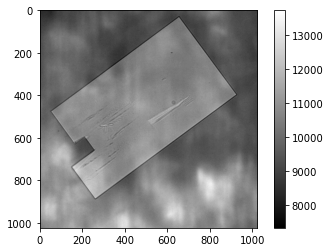

In [7]:
# Let's plot a specific image
%matplotlib inline
plt.imshow(images[1],cmap='gray')
plt.colorbar()

In [8]:
# We can also load the images into hyperspy which makes it easy for us to look at the whole series
%matplotlib qt
s = hs.signals.Signal2D(images)
s.plot()

In [9]:
def get_pixel_size(fpath):
    f = h5py.File(fpath,'r')
    scale = f['Cube/Info/Camera'].attrs['PixelSizeNm'][0] #in nm/pixel, this is the camera pixel size, not the image pixel size!!
    magnification = int(f['Cube/Info/Optics'].attrs['Objective'][0][:-1]) # need to strip 'x' symbol at end

    pixel_size = scale/(1000*magnification) # this is the image pixel calibration in um/px

    # print(r'Our image has %.3f pixels per um' % pixel_size) # should be other way around?
    return pixel_size

def get_image_size(im, f):
    # Figure out max extent of image for scaling
    im_shape= np.array(np.shape(im))
    im_length = im_shape*get_pixel_size(f)
    return im_length

f = h5py.File(fpaths[0],'r')
print(get_image_size(image3, f)[0])
# %matplotlib qt
# i = 0 # choose frame to plot
# plt.imshow(images[i],cmap='gray',extent=[0,im_length[0],0,im_length[1]],vmin=np.min(images),vmax=np.max(images))
# plt.colorbar()
# plt.xlabel(r'$x / \mu m$', fontsize=15)
# plt.ylabel(r'$y / \mu m$', fontsize=15)
# plt.title('t = %.2f s' % ts[i])

NameError: name 'image3' is not defined

Image pre-processing

In [10]:
def blur_image(im, k_blur = 9):
    # Blur image
    blurred = cv2.GaussianBlur(im, (k_blur, k_blur), 0)
    return blurred

def open_image(im, k_open = 9):
    # Open image
    kernel = np.ones((k_open,k_open),np.uint8)
    opening = cv2.morphologyEx(im,cv2.MORPH_OPEN,kernel)
    return opening

def sobel_2D(im, k_sobel = 15):
    # Sobel filter
    # Basically finds strong gradients going both ways for each pixel and adds them to come up with a sort of approximate
    # Isn't quite contours yet but is making what should be contours stand out.
    sobelx = cv2.Sobel(im,cv2.CV_64F,1,0,ksize=k_sobel)
    sobely = cv2.Sobel(im,cv2.CV_64F,0,1,ksize=k_sobel)
    sobel = abs(sobelx) + abs(sobely)
    # sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = sobel/np.max(sobel)
    return sobel

def threshold_image(im):
    # just takes data above threshold value and makes binary it seems
    # Filters out some of the background murk
    thresh = cv2.threshold(im, np.max(im)/5, 1, cv2.THRESH_BINARY)[1].astype(np.uint8) # data type change again is preferred by cv2 for this bit for whatever reason.
    return thresh

def get_binary(im):
    return threshold_image(sobel_2D(open_image(blur_image(im))))

In [11]:
def get_contours(binary):
    """ Given a binary image, returns contours 
    Contours must be above an area/perimeter threshold"""
    try:
        contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    # need to ask George what going on with this next bit. Apparently was for messing around with different versions.
    except:
        try:
            _,contours, _ = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        except:
            contours, hierarchy = cv2.findContours(binary,cv2.RETR_FLOODFILL,cv2.CHAIN_APPROX_SIMPLE)
    big_cnt = []
    areas = []
    perims = []

    for c in contours:
        area = cv2.contourArea(c)
        perim = cv2.arcLength(c,True)
        if area > 3000 or perim > 2000:
            big_cnt.append(c)
            areas.append(area)
            perims.append(perim)
#         if np.shape(c)[0] > 150:
#             big_cnt.append(c)

    return big_cnt, areas, perims

def plot_contours(cnts,im,title=None):
    """ Takes contours and an image, and plots them both"""
    plt.figure()
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        plt.scatter(cnts[i][:,0][:][:,0],cnts[i][:,0][:][:,1],s=2,color=cols[i%len(cols)],alpha=0.4)
        plt.imshow(im,cmap='gray')
    if title != None:
        plt.title(title,fontsize=15)
    plt.axis('off')
    plt.show()

In [12]:
### Experimenting with different pre-processing

# im = images[0]
# %matplotlib inline
# plt.imshow(im)
# plt.show()

# honestly, looking at just one frame, possible new2 is best at least visually https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html
# plt.imshow(sobel_2D(im))
# plt.show()

# new1=(blur_image(im))

# plt.imshow(sobel_2D(new1))
# plt.show()

# new2=(open_image(im))

# plt.imshow(sobel_2D(new2))
# plt.show()

# new3=open_image(blur_image(im))

# plt.imshow(sobel_2D(new3))
# plt.show()


### Experimenta; plotting of area and perimeter

# area_plot = []
# perim_plot = []

# for im in images:
#     bim = get_binary(im)
#     contours_filtered, areas_filtered, perims_filtered = get_contours(bim)
#     biggest_area = np.max(areas_filtered)
#     biggest_perim = np.max(perims_filtered)
#     area_plot.append(biggest_area)
#     perim_plot.append(biggest_perim)
    
# %matplotlib inline
# plt.plot(area_plot,'.-')
# plt.xlabel('Index', fontsize=15)
# plt.ylabel('Area /', fontsize=15)
# plt.show()
# plt.plot(perim_plot)
# plt.xlabel('Index', fontsize=15)
# plt.ylabel('Perim /', fontsize=15)
# plt.show()
    
    
#plot_contours(contours_filtered,im)
#print(areas_filtered, perims_filtered)


# make a cell that extracts everything I need to inspect, and then have a look.

In [13]:
folder = r'C:\Users\es758\Documents\Python Scripts\Mini 1\Reflection data subset\\'
ts, images = get_data_h5py(folder)

In [14]:
def get_contour_data(images):
    contour_sets = []
    area_sets = []
    perim_sets = []
    for im in images:
        bim = get_binary(im)
        contours_filtered, areas_filtered, perims_filtered = get_contours(bim)
        contour_sets.append(contours_filtered)
        area_sets.append(areas_filtered)
        perim_sets.append(perims_filtered)
    return contour_sets, area_sets, perim_sets

It would seem that areas are more reliable than perimeters. Have to handle multiple contours that are basically the same, drops whilst the data is still good, and then dealing with it falling apart when touching the edge

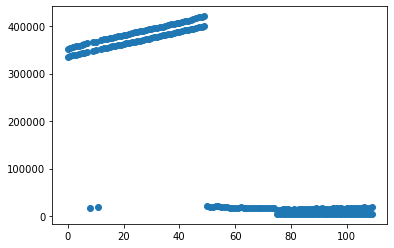

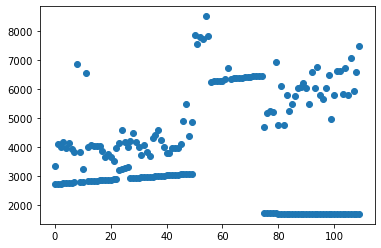

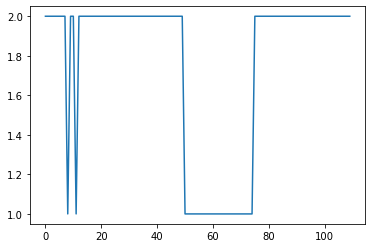

In [15]:
contour_sets, area_sets, perim_sets = get_contour_data(images)   

index_list = []
area_list = []
perimeter_list = []
for i in np.arange(len(area_sets)):
    for j in np.arange(len(area_sets[i])):
        index_list.append(i)
        area_list.append(area_sets[i][j])
        perimeter_list.append(perim_sets[i][j])
    

    
%matplotlib inline
plt.scatter(index_list,area_list)
plt.show()

plt.scatter(index_list,perimeter_list)
plt.show()

num_entries = []
for i in np.arange(len(area_sets)):
    num_entries.append(len(area_sets[i]))
    
plt.plot(num_entries)
plt.show()

In [18]:
%matplotlib qt
index = 5
plot_contours(contour_sets[index], get_binary(images[index]))

# 11 is a single contour, not sure why hasn't worked with area

# 50 seems to be both where area falls apart and where the crystal touches the edge


## Look at later
# reason is sometimes making 2 and 1 is is putting an inside and an outside. Can play with opening to get rid of double threshold. Can try closing too. Want 2 edges to merge together.

In [22]:
contour_sets, area_sets, perim_sets = get_contour_data(images)

%matplotlib inline


def extract_best_contour_data(contour_sets, area_sets, perim_sets):
    best_contours = []
    best_areas = []
    best_perims = []
    for i in np.arange(len(contour_sets)):
        criterion = np.max(area_sets[i])
        best_areas.append(criterion)
        j = area_sets[i].index(criterion)
        best_contours.append(contour_sets[i][j])
        best_perims.append(perim_sets[i][j])
    return best_contours, best_areas, best_perims
        

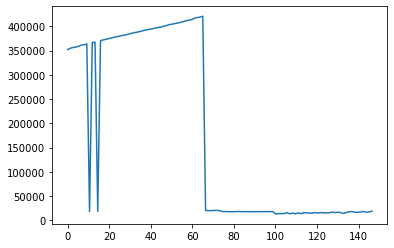

In [23]:
best_contours, best_areas, best_perims = extract_best_contour_data(contour_sets, area_sets, perim_sets)
plt.plot( ts, best_areas)

In [24]:
def extract_growth_rate(area_series, time_series):
    gro_series = []
    index_list = np.arange(len(area_series))
    for i in index_list:
        if i == 0:
            rate = (area_series[1] - area_series[0])/(time_series[1]-time_series[0])
        elif i == index_list[-1]:
            rate = (area_series[-1] - area_series[-2])/(time_series[-1]-time_series[-2])
        else:
            rate = (area_series[i+1] - area_series[i-1])/(time_series[i+1]-time_series[i-1])
        gro_series.append(rate)
    return gro_series
            
# def fix_area_data(area_series, time_series):
#     """
#     Interpolates area if contours fail for a time and slices data to just frames before the crystal reaches the edge of the field of view
#     Maybe add later a way of marking data where have done this?
#     Probably could do something smart with try and except here.
#     """
    
#     gro_series = extract_growth_rate(area_series, time_series)
    
#     cleaned_area_series = []
#     cleaned_time_series = []
    
#     # maybe should tell by rate instead? But need to distinguish between blips and edge so both I reckon
#     index_list = np.arange(len(area_series))
#     for i in index_list:
#         if i == 0 or i == index_list[-1]:
#             cleaned_area_series.append(area_series[i])
#         elif abs(gro_series[i]) > 10*abs(gro_series[i-1]):
#             # check if area value has collapsed due to reaching the edge of the field of view
#             # should probably have warnings that either the area has reached the edge or just got unlucky with which evaluations failed. WIll for now make reliant on not getting 2 bad
#             # in a row for sake of catching dodgy data
#             if area_series[i+1] < area_series[i-1]:
#                 # cut off
#                 cleaned_time_series = time_series[:len(cleaned_area_series)]
#                 break
#             else:
#                 #interpolate
#                 area_interp = [area_series[i-1], area_series[i+1]]
#                 time_interp = [time_series[i-1], time_series[i+1]]
#                 f = interp1d(time_interp, area_interp, kind='linear')
#                 cleaned_area_series.append(f(time_series[i]))
#         else:
#             cleaned_area_series.append(area_series[i])
                
    
#     return cleaned_area_series, cleaned_time_series
def fix_area_data(area_series, time_series):
    """
    Interpolates area if contours fail for a time and slices data to just frames before the crystal reaches the edge of the field of view
    Maybe add later a way of marking data where have done this?
    Probably could do something smart with try and except here.
    """
    cleaned_area_series = []
    cleaned_time_series = []
    
    # maybe should tell by rate instead? But need to distinguish between blips and edge so both I reckon
    index_list = np.arange(len(area_series))
    for i in index_list:
        if i == 0 or i == index_list[-1]:
            cleaned_area_series.append(area_series[i])
        elif i == 1:
            cleaned_area_series.append(area_series[i])
        elif abs(area_series[i]-cleaned_area_series[i-1]) > 100*abs(cleaned_area_series[i-1]-cleaned_area_series[i-2]):
    
            if area_series[i+1] < cleaned_area_series[i-1]:
                # cut off
                # could try make so allows thing to shrink
                cleaned_time_series = time_series[:len(cleaned_area_series)]
                break
            else:
                #interpolate
                area_interp = [cleaned_area_series[i-1], area_series[i+1]]
                time_interp = [time_series[i-1], time_series[i+1]]
                f = interp1d(time_interp, area_interp, kind='linear')
                cleaned_area_series.append(f(time_series[i]))
        else:
            cleaned_area_series.append(area_series[i])
                
    # am I misssing an apend time series somewhere?
    # At present ok because take whole time series once touches edge but should 
    # I suppose an alternative to what I have done would be to just skip out area and time rather than interpolating. Especially if messes up later in facets.
    return cleaned_area_series, cleaned_time_series

# cut off happens if more than 2 blips in a row as well as for normal cut off
# blip detection works ok but if only one normal value inbetween 2 blips I don't think it will recognise the second one. 
# therefore maybe I should change so makes new area list to reference past values as it goes rather than what doing now. Future i ones can still be the original.
#this simple change to above so will do

# weakness still can't handle if area contours mess up more than a few tiems and can't tell if because if hit edge or is this. Most likely edge though.



# probably change to skipping out, can't gain much from interpolation. Not adding information. Tell it to put Nan? But handle for growth rate. Is then a flag for where data missing.

# try remove the double threshold. Hard to play with to make general but could try put some things in place.
# 


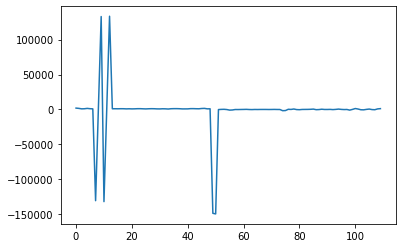

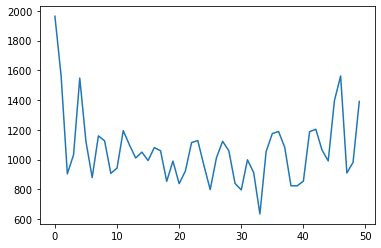

In [25]:
plt.plot(extract_growth_rate(best_areas, ts))
plt.show()
cleaned_area_series, cleaned_time_series = fix_area_data(best_areas, ts)
plt.plot(extract_growth_rate(cleaned_area_series, cleaned_time_series))
plt.show()
# breaks after 6 but not terrible. Clearly got to check for more up and down or maybe closer errors like that.

In [26]:
# was cutting data off after only 7 seconds or so
# ahh, problem is growth rates based on future entry so had a problem in the one before the drop in area.

# have changed function to be areas based alone.
# should build in so can look at data before choosing how to clean or if clean and results sensible. Or at least throw warnings based on what has done.

In [27]:
# probably worth using scipy to curve fit with errors etc for areas to see what growth rate is predicted as like on average.
# should also add units and make propert figures.

In [28]:
def rotate_image(im, angle):
    row, col = im.shape
    image_centre = tuple(np.array([row, col])/2)
    rot_mat = cv2.getRotationMatrix2D(image_centre, angle, 1.0)
    result = cv2.warpAffine(im, rot_mat, (col, row), flags=cv2.INTER_LINEAR) # warpAffine takes shape in reverse order
    return result

def onedimify(im):
    #row, col = im.shape
    im_1D_av = []
    for row in im:
        im_1D_av.append(np.average(row))
    return im_1D_av

def find_alignment(im, step_degree=1):
    angles = np.arange(0, 90+step_degree, step_degree) # if only allow 90 degrees won't necessarily find the alignement with the 
    # longest face because it doesn't rotate back, I've tried. Need to let it do 180 degrees.
    # better to do this than not know which it is finding? Or maybe if end up extracting growth rate both directions then doesn't matter
    biggest_signals = []
    for angle in angles:
        rotated_image = rotate_image(im, angle)
        onedim = onedimify(rotated_image)
        biggest_signals.append(np.max(onedim))
    best_alignment = angles[biggest_signals.index(np.max(biggest_signals))]
    return best_alignment

In [29]:
image3=images[4].copy()
sobel = sobel_2D(open_image(blur_image(image3)))
print(find_alignment(sobel, 1))

54


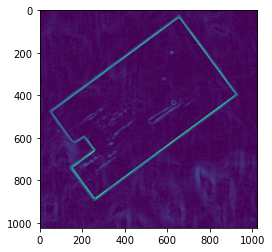

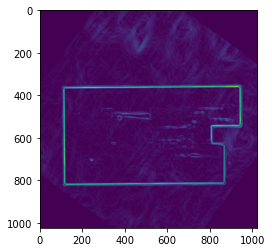

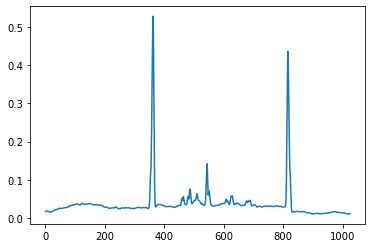

In [30]:
plt.imshow(sobel)
plt.show()
plt.imshow(rotate_image(sobel, 144))
plt.show()
plt.plot(onedimify(rotate_image(sobel, 144)))

# in this case, actually probably more interesting to look at rate in other direction.
# maybe sensible thing is to find 2 biggest spikes, track both, and do same for other direction. Take biggest from each.
# then have estimate of x and y growth.

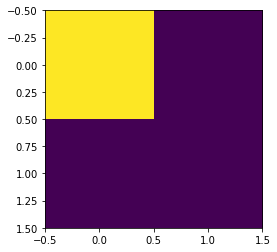

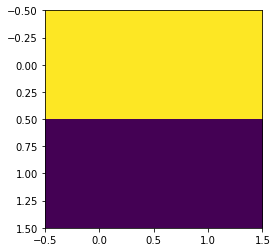

In [31]:
a=np.array([[1,0],[0,0]])
plt.imshow(a)
plt.show()
a=np.array([[1,1],[0,0]])
plt.imshow(a)
plt.show()

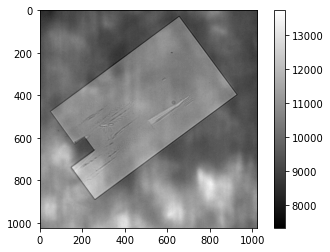

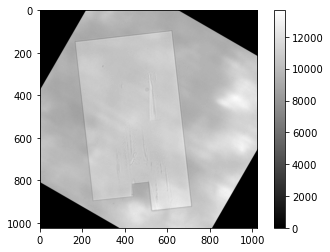

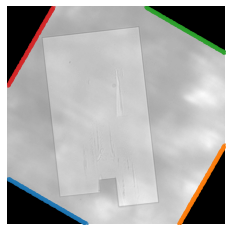

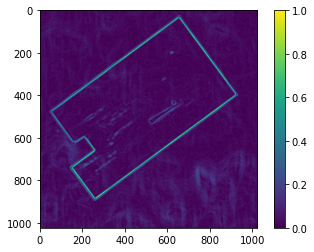

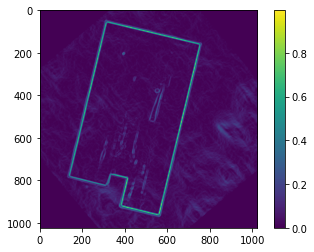

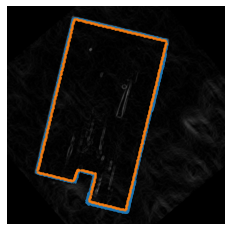

In [32]:
image = images[3]
%matplotlib inline
plt.imshow(image,cmap='gray')
plt.colorbar()
plt.show()
ro_image= rotate_image(image, 60)
plt.imshow(ro_image,cmap='gray')
plt.colorbar()
plt.show()



cnts, areas, per = get_contours(get_binary(ro_image))
plot_contours(cnts,ro_image)

# What I am learning instantly is perhaps it will only be safe to rotate the binary? Or probably the Sobel image actually.
# not sure what would happen if tried to linearly interpolate a binary so sobel.
# maybe need to do better interpolation too?
# maybe should set black areas to minimum of normal image? nah probs won't work.
# probably just the first thing.

image2=image.copy()
sobel = sobel_2D(open_image(blur_image(image2)))
plt.imshow(sobel)
plt.colorbar()
plt.show()

ro_image2= rotate_image(sobel, 40)
plt.imshow(ro_image2)
plt.colorbar()
plt.show()

# is a bit better but what will contours do as border still weird? Seems to be ok actually.

cnts, areas, per = get_contours(threshold_image(ro_image2))
plot_contours(cnts,ro_image2)

In [33]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2=[0,1]):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
            
            
            Changed now to give degrees
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))/np.pi)*180

v1 = [1,0]
#v2=[0,1]

angle_between(v1)

90.0

In [ ]:


def manual_detection(im,max_shapes=20):
    """ Manually click out a line"""
    # Show image
    plt.imshow(im,cmap='Greys_r')
    plt.axis('off')
    all_points = []
    all_s = []
    # Get user input
    for i in range(max_shapes):
        plt.title('Shape %i \n Left click to add (up to 2) points \
        \n Right click for next shape \
        \n Middle click to remove a point (Use when zooming) \
        \n Finish by right clicking without adding points' %i,fontsize=8)
        points = plt.ginput(n=2, show_clicks=True,mouse_stop=3,mouse_pop=2)
        if points == []:
            break
        else:
            all_points.append(points)

            # Convert points to contour
            # s = np.array(points).reshape((-1,1,2)).astype(np.int32)
            # Convert points to line pairs
            s = np.array(points)
            all_s.append(s)

            # Plot shape
            # x1,x2 = s[:][0,0][0],s[:][-1,0][0]
            # y1,y2 = s[:][0,0][1],s[:][-1,0][1]
            # plt.plot(s[:,0][:][:,0],s[:,0][:][:,1],'o-',color='r',alpha=.6)
            # plt.plot([x1,x2],[y1,y2],'o-',color='r',alpha=.6,label=None)
        
    plt.close()
        

    return all_s

%matplotlib qt
a=(manual_detection(image3))
print(a)
line = a[0][1]-a[0][0]
print(line)
angle_between(line)

# current selection is from head of arrow to tail, could fix easy
# also returns angle to vertical without sign right now. So not sure which way to rotate.
# still, progress is progress.
# my rotations seem to be anticlockwise so at the moment only the right side will give the correct.
# not the correct fix, but could say depending on where second point is relative to first will flip the sign.


# maybe to help selection should put first and last contour over each other in a plot?





In [ ]:
# whilst current contour stuff only seems to works for crystals in the middle, 
# maybe facet growth rate finding might work as not actualy dependent on contours.

# I think to develop to include side crystals and stuff need a dataset that actually has.

In [ ]:
a=np.NaN
print(np.isnan(a))